In [1]:
import numpy as np
import emcee
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import corner
from IPython.display import display, Math
import pandas as pd
import scipy

# Defining functions and likelihoods

In [2]:
#------ BACKGROUND EQUATIONS ------

# Equation 2.14
def Omega_Lambda(cosmo):
    Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    
    return 1 - Omega_m - Omega_r - Omega_k + alpha_tilde * (1 - C_t**2 + Omega_k**2 - 2*Omega_k)

# Equation 2.13
def X(z, cosmo):
    
    Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = Omega_Lambda(cosmo)
    
    return 1 + 4 * alpha_tilde * (Omega_m * (1 + z) ** 3 + (Omega_r + alpha_tilde*C_t**2) * (1 + z)** 4 + Omega_lambda)

# Equation 2.12
def E(z , cosmo):
    
    Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = Omega_Lambda(cosmo)
    
    E_L = Omega_m * (1 + z) ** 3 + (Omega_r + alpha_tilde*C_t**2) * (1 + z) ** 4 + Omega_k * (1 + z) ** 2 + Omega_lambda
    
    if alpha_tilde == 0:
        ans = np.sqrt(E_L + Omega_k * (1 + z) ** 2)
    
    # small alpha approximation to deal with numerical instabilities
    elif alpha_tilde < 1e-10 and E_L < 1e4:
        ans = np.sqrt(E_L + Omega_k * (1 + z) ** 2 - alpha_tilde* (E_L**2)/4)
    
    else:
        ans = np.sqrt((np.sqrt(X(z , cosmo)) - 1 + (2 * alpha_tilde * Omega_k * (1+z) ** 2))/(2 * alpha_tilde))
    
    return ans


In [3]:
# ------ equations for BAO ------ c = 1

# Angular diameter distance
def D_M_H0(z,cosmo):
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = Omega_Lambda(cosmo)

    D = np.zeros(len(z))
    for i in range(len(z)):
        chi = scipy.integrate.quad(lambda x: 1/E(x,cosmo), 0 , z[i])[0]
        if Omega_k > 0:
            D[i] = np.sinh(np.sqrt(Omega_k)*chi)/np.sqrt(Omega_k)
        elif Omega_k < 0:
            D[i] = np.sin(np.sqrt(Omega_k)*chi)/np.sqrt(Omega_k)
        else:
            D[i] = chi
    return D

# Hubble distance
def D_H_H0(z,cosmo):
    D = np.zeros(len(z))
    for i in range(len(z)):
        D[i] = 1/E(z[i],cosmo)
    return D

# Spherically-averaged distance (historical BAO distance)
def D_V_H0(z,cosmo):
    return (z*D_H_H0(z,cosmo)*D_M_H0(z,cosmo)**2)**(1/3)

# Used to find z_CMB
def g1(wb):
    return (0.0783*wb**(-0.238))/(1 + 39.5*wb**(0.763))

# Used to find z_CMB
def g2(wb):
    return 0.56/(1 + 21.1*wb**(1.81))

# redshift at which the BB occurs -- note that for wb approx 0 z_CMB = z_d (drag epoch)
def z_CMB(Omg_b,Omg_m,h):
    wb = Omg_b * h**2
    wm = Omg_m * h**2
    return 1048*(1+0.00124*wb**(-0.738))*\
           (1 + g1(wb)*wm**g2(wb))

# Used to find r_s - only works for 0.0025 < wb < 0.25 and 0.025 < wm < 0.64 
def R_b(wb):
    return 31500*wb*(2.7255/2.7)**(-4)

# Note that we assumed sound horizon was zero at the end of nucleosynthesis
def r_d_H0(cosmo,h):
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    
    return scipy.integrate.quad(lambda x: 1/((x**2)*E(1/x -1, cosmo)*np.sqrt(3*(1 + R_b(Omega_b*h**2)*x))), 2.5e-9, 1/(1+z_CMB(Omega_b,Omega_m,h)))[0]

In [4]:
def log_likelihood_DV(theta, z, y, cov):
    # note: c in km/s, H in km/s/Mpc and D_A in Mpc
    # note: log likelihood = -chi^2/2

    Omg_c, h, alpha_t = theta 
    Omg_b = 0.05 
    
    Omg_r = (2.47e-5*h**-2)*1.6949484 # last factor due to neutrinos
    model = D_V_H0(z,[Omg_c , Omg_b , 0 , Omg_r , alpha_t,0])/r_d_H0([Omg_c , Omg_b , 0 , Omg_r , alpha_t,0],h)
    
    return -0.5 * np.matmul(np.matmul((y-model),np.linalg.inv(cov)),np.transpose(y-model))

In [5]:
def log_likelihood_DM(theta, z, y, cov):
    # note: c in km/s, H in km/s/Mpc and D_A in Mpc
    # note: log likelihood = -chi^2/2

    Omg_c, h, alpha_t = theta 
    Omg_b = 0.05 
    
    Omg_r = (2.47e-5*h**-2)*1.6949484 # last factor due to neutrinos
    model = D_M_H0(z,[Omg_c, Omg_b , 0 , Omg_r , alpha_t,0])/r_d_H0([Omg_c, Omg_b , 0 , Omg_r , alpha_t,0],h)
    return -0.5 * np.matmul(np.matmul((y-model),np.linalg.inv(cov)),np.transpose(y-model))

In [6]:
def log_likelihood_DH(theta, z, y, cov):
    # note: c in km/s, H in km/s/Mpc and D_A in Mpc
    # note: log likelihood = -chi^2/2
    Omg_c, h, alpha_t = theta 
    Omg_b = 0.05 

    Omg_r = (2.47e-5*h**-2)*1.6949484 # last factor due to neutrinos
    model = D_H_H0(z,[Omg_c, Omg_b , 0 , Omg_r , alpha_t,0])/r_d_H0([Omg_c, Omg_b , 0 , Omg_r , alpha_t,0],h)
    return -0.5 * np.matmul(np.matmul((y-model),np.linalg.inv(cov)),np.transpose(y-model))

In [7]:
# SPECIFIC TO MGS DATA
# takes a dataframe with chisquared and D_V/D_{V,fid}*r_{d,fid}/r_d 
# and returns a likelihood for a given theta
def log_likelihood_MGS(theta , df):
    z =  [0.15,0.15] # use array just because I've been using arrays in other functions. at the end select [0]
    Omg_c, h, alpha_t = theta 
    Omg_b = 0.05 
    Omg_r = (2.47e-5*h**-2)*1.6949484

    D_V_fid_MGS = 638.95 # Mpc
    r_d_fid_MGS = 148.69 # Mpc
    likelihood_tointerpolate = np.array(-df["chisquared"]/2)
    D_V_rd_tointerpolate = np.array(df["D_V_etc"])*D_V_fid_MGS/r_d_fid_MGS
    D_V_rd_theory = D_V_H0(z,[Omg_c , Omg_b , 0 , Omg_r , alpha_t,0])/r_d_H0([Omg_c , Omg_b , 0 , Omg_r , alpha_t,0],h)
    return np.interp(D_V_rd_theory, D_V_rd_tointerpolate, likelihood_tointerpolate)[0]

In [8]:
def log_likelihood_BOSSG(theta, df, df_cov):
    # note: c in km/s, H in km/s/Mpc and D_A in Mpc
    # note: log likelihood = -chi^2/2
    z = np.array(df["z"])
    y = np.array(df["D_M_frac_rd_fid_rd_or_H_frac_rd_rd_fid"])
    cov = np.matrix(df_cov)
    Omg_c, h, alpha_t = theta 
    Omg_b = 0.05 
    r_d_fid = 147.78
    
    Omg_r = (2.47e-5*h**-2)*1.6949484 # last factor due to neutrinos
    model = [r_d_fid*D_M_H0(z,[Omg_c , Omg_b , 0 , Omg_r , alpha_t,0])[0]/r_d_H0([Omg_c , Omg_b , 0 , Omg_r , alpha_t,0],h),
             3e5/(r_d_fid*D_H_H0(z,[Omg_c, Omg_b , 0 , Omg_r , alpha_t,0])[0]/r_d_H0([Omg_c, Omg_b , 0 , Omg_r , alpha_t,0],h)),
             r_d_fid*D_M_H0(z,[Omg_c , Omg_b , 0 , Omg_r , alpha_t,0])[1]/r_d_H0([Omg_c , Omg_b , 0 , Omg_r , alpha_t,0],h),
             3e5/(r_d_fid*D_H_H0(z,[Omg_c, Omg_b , 0 , Omg_r , alpha_t,0])[1]/r_d_H0([Omg_c, Omg_b , 0 , Omg_r , alpha_t,0],h))
            ]
    
    return -0.5 * np.matmul(np.matmul((y-model),np.linalg.inv(cov)),np.transpose(y-model))

In [9]:
def log_prior(theta):
    Omg_c, h, alpha_t = theta 
    Omg_b = 0.05 
    wb = Omg_b*h**2
    wm = (Omg_c + Omg_b)*h**2
    if 0.025 < wm < 0.64 and 0.5 < h < 1 and -1e-50 < alpha_t < 1 :
        return 0.0
    return -np.inf

In [10]:
def log_probability(theta, x, y, sigma):
    lp = log_prior(theta)
    
    df_MGS, df_BOSS_G, x1 = x
    df_cov_BOSS_G, sigma1 = sigma
    x_v, x_m, x_h = x1
    y_v, y_m, y_h = y
    yerr_v, yerr_m, yerr_h = sigma1
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_MGS(theta,df_MGS) + log_likelihood_BOSSG(theta, df_BOSS_G, df_cov_BOSS_G)\
            + log_likelihood_DV(theta, x_v, y_v, yerr_v) + log_likelihood_DM(theta, x_m, y_m, yerr_m)\
            + log_likelihood_DH(theta, x_h, y_h, yerr_h)

# correct for now: MGS, BOSS_G

# Getting the data

This is the data we will use (explanation taken from Alam+2020 THE COMPLETED SDSS-IV EXTENDED BOSS)
1. Main Galaxy Sample (MGS): 

    a. Ross+2015 https://arxiv.org/pdf/1409.3242.pdf 
    
    b. data from arxiv .dat file. Saved locally as chid_MGSconsensus.dat
    
    c. Gives us D_V/D_{V,fid}*r_{d,fid}/r_d with values for D_v_fid and rd_fid
    
2. BOSS DR12 Galaxies (BOSS Galaxies): 

    a. Alam+2017 https://arxiv.org/pdf/1607.03155.pdf 
    
    b. data from https://sdss3.org/science/boss_publications.php. Saved BAO-only locally in All_BAO_Alam2016_data/COMBINEDDR12_BAO_consensus_dM_Hz. This is equivalent to Table 7 BAO-only in Alam+2017
    
    b. "These results were computed over all three redshift intervals after fully accounting for systematic errors and covariances between parameters and between redshift bins"
    
    c. Gives us D_M(rsfid/rs) and Hz(rs/rsfid) and rsfid for BAO-only measurements - we drop z = 0.61 to match DESY3 paper

Note that we get the gaussian likelihood estimates (just for plots) from Alam+2020 

In [11]:
# GET PROPER LIKELIHOODS (they aren't gaussian)

# MGS data - Ross+2015
#For our fiducial cosmology (Flat, Omega_matter=0.31, h =0.67), 
# $D^{\rm fid}_V(z) = 638.95$ Mpc and $r_d^{\rm fid} = 148.69$ Mpc.
# D_V_etc = D_V/D_{V,fid}*r_{d,fid}/r_d 

df_DV_MGS = pd.read_csv('~/Desktop/Newcastle/4DEGB/Data/chid_MGSconsensus.dat',delim_whitespace=True)

# TO TEST THE log_likelihood_MGS FUNCTION (ie. that log_likelihood_MGS(theta,df_DV_MGS) gives us the likelihood for a given set of params)

#Omg_c = np.linspace(0,1,100)
#Omg_b = 0.05
#h = 1.6
#alpha_t = 0

#plt.plot(y_MGS_Dv_over_rd*np.ones(int(1e2)), np.linspace(-5,0,int(1e2)), "k--")
#plt.plot((y_MGS_Dv_over_rd +yerr_MGS_Dv_over_rd)*np.ones(int(1e2)), np.linspace(-5,0,int(1e2)), "k--")
#plt.plot((y_MGS_Dv_over_rd -yerr_MGS_Dv_over_rd)*np.ones(int(1e2)), np.linspace(-5,0,int(1e2)), "k--")
#for i in range(len(Omg_c)):
#    theta = [Omg_c[i], h, alpha_t]
#    Omg_r = (2.47e-5*h**-2)*1.6949484 # last factor due to neutrinos
#    plt.plot(np.array(df_DV_MGS["D_V_etc"])*D_V_fid_MGS/r_d_fid_MGS, np.array(-df_DV_MGS["chisquared"]/2))
#    plt.scatter(D_V_H0([0.15,0.15],[Omg_c[i] , Omg_b , 0 , Omg_r , alpha_t,0])[0]/r_d_H0([Omg_c[i] , Omg_b , 0 , Omg_r , alpha_t,0],h),log_likelihood_MGS(theta,df_DV_MGS))

In [12]:
# BOSS Galaxies data - Alam+2016
# For our fiducial cosmology r_d_fid = 147.78 Mpc
# returns D_M*rd_fid/rd (in Mpc) and H*rd/rd_fid (in km/(sMpc))
# Note: H*rd/rd_fid = 3e5/(D_H_over_rd*r_d_fid)

df_DV_BOSSG = pd.read_csv('~/Desktop/Newcastle/4DEGB/Data/All_BAO_Alam2017_data/COMBINEDDR12_BAO_consensus_dM_Hz/BAO_consensus_results_dM_Hz.txt',delim_whitespace=True)
df_cov_BOSSG = pd.read_csv('~/Desktop/Newcastle/4DEGB/Data/All_BAO_Alam2017_data/COMBINEDDR12_BAO_consensus_dM_Hz/BAO_consensus_covtot_dM_Hz.txt',delim_whitespace=True, header=None)

print(df_DV_BOSSG)
print(np.matrix(df_cov_BOSSG))

# compare to paper values: D_M_over_rd = 10.23,13.36, err = 0.17,0.21
# and D_H_over_rd = 25,22.33, err = 0.76,0.58

      z  D_M_frac_rd_fid_rd_or_H_frac_rd_rd_fid
0  0.38                               1512.3900
1  0.38                                 81.2087
2  0.51                               1975.2200
3  0.51                                 90.9029
[[624.707    23.729   325.332     8.34963]
 [ 23.729     5.60873  11.6429    2.33996]
 [325.332    11.6429  905.777    29.3392 ]
 [  8.34963   2.33996  29.3392    5.42327]]


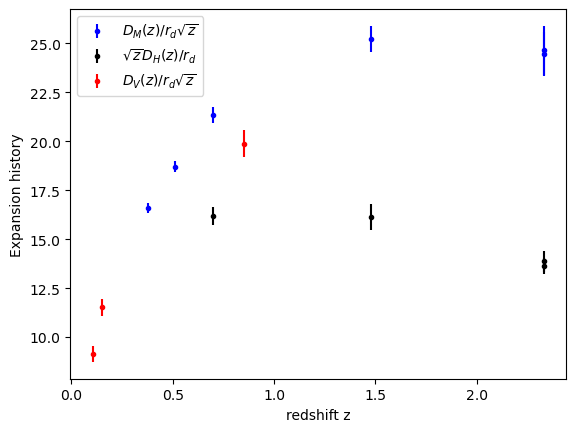

In [13]:
#get the data if we assume gaussian likelihoods

# BOSS Galaxy, eBOSS LRG, eBOSS Quasar =, Ly\alpha-Ly\alpha and Ly\alpha-Quasar data
x_D_mh_over_rd = np.array([0.70,1.48,2.33,2.33])

y_D_m_over_rd = np.array([17.86,30.69,37.6,37.3])
yerr_D_m_over_rd =np.diag([0.33,0.8,1.9,1.7])

y_D_h_over_rd = np.array([19.33,13.26,8.93,9.08])
yerr_D_h_over_rd =np.diag([0.53,0.55,0.28,0.34])

# eBOSS ELG data
x_ELG = 0.85
y_ELG_Dv_over_rd = 18.33
yerr_ELG_Dv_over_rd = 0.62 # TODO how do you account for different max/min?

# 6dFGS data
x_6dFGS = 0.106
y_6dFGS_Dv_over_rd = 1/0.336
yerr_6dFGS_Dv_over_rd = 0.015/0.336**2

# Note: this is just for display and the full likelihood is what we use for param estimation
rd_fid = 148.69
x_MGS = 0.15
y_MGS_Dv_over_rd = 664 / rd_fid
yerr_MGS_Dv_over_rd = 25 / rd_fid # TODO check


# Combine data
x = [np.array([x_ELG,x_6dFGS]),x_D_mh_over_rd,x_D_mh_over_rd]
y = [np.array([y_ELG_Dv_over_rd,y_6dFGS_Dv_over_rd]),y_D_m_over_rd,y_D_h_over_rd]
sigma = [np.diag([yerr_ELG_Dv_over_rd**2,yerr_6dFGS_Dv_over_rd**2]) , yerr_D_m_over_rd**2 , yerr_D_h_over_rd**2]

# Plot our data - all remaining
plt.errorbar(x_D_mh_over_rd, y_D_m_over_rd/np.sqrt(x_D_mh_over_rd), yerr=np.diag(yerr_D_m_over_rd/np.sqrt(x_D_mh_over_rd)), fmt=".b", capsize=0, label = r"$D_M(z)/r_d\sqrt{z}$")
plt.errorbar(x_D_mh_over_rd, y_D_h_over_rd*np.sqrt(x_D_mh_over_rd), yerr=np.diag(yerr_D_h_over_rd)*np.sqrt(x_D_mh_over_rd), fmt=".k", capsize=0, label = r"$\sqrt{z}D_H(z)/r_d$")

# Plot our data - 6dFGS, MGS
plt.errorbar([x_6dFGS,x_MGS,x_ELG], [y_6dFGS_Dv_over_rd/np.sqrt(x_6dFGS), y_MGS_Dv_over_rd/np.sqrt(x_MGS), y_ELG_Dv_over_rd/np.sqrt(x_ELG)],\
             yerr=[yerr_6dFGS_Dv_over_rd/np.sqrt(x_6dFGS), yerr_MGS_Dv_over_rd/np.sqrt(x_MGS), yerr_ELG_Dv_over_rd/np.sqrt(x_ELG)], fmt=".r", capsize=0, label = r"$D_V(z)/r_d\sqrt{z}$")

# Plot our data - BOSS Galaxies
plt.errorbar([0.38,0.51], [10.23/np.sqrt(0.38),13.36/np.sqrt(0.51)], [0.17/np.sqrt(0.38),0.21/np.sqrt(0.51)], fmt=".b", capsize=0,)
plt.legend()
x0 = np.linspace(0, 10, 500)
plt.xlabel("redshift z")
plt.ylabel("Expansion history");

# Processing the data

In [14]:
# Choose the seed parameters.
Omg_c_est = 0.3
h_est = 0.5
alpha_t_est = 0.01

In [15]:
#MCMC method

# initializing the walkers in a tiny Gaussian ball around the maximum likelihood result
#and then run 10,000 steps of MCMC
pos = [Omg_c_est , h_est, alpha_t_est] + 1e-4 * np.random.randn(50, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=([df_DV_MGS, df_DV_BOSSG, x], y, [df_cov_BOSSG, sigma])
)
sampler.run_mcmc(pos, 1000, progress=True);

  0%|                                                  | 0/1000 [00:00<?, ?it/s]/home/c2042999/anaconda3/envs/4DEGB_venv2/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 13%|█████▏                                  | 130/1000 [03:46<25:18,  1.75s/it]


ValueError: If you start sampling with a given log_prob, you also need to provide the current list of blobs at that position.

In [33]:
print(sampler.get_blobs())

None


In [ ]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
labels = ["Omg_c", "h", "alpha_t"]
print(flat_samples.shape)

fig = corner.corner(
    flat_samples, labels=labels
);

50
376
3
376


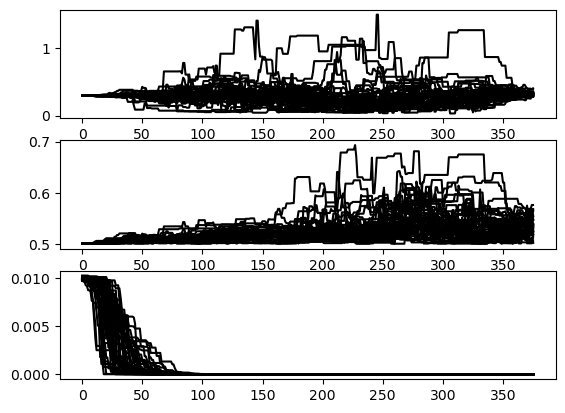

In [531]:
samples_chain = sampler.chain
print(len(samples_chain))
print(len(samples_chain[0]))
print(len(samples_chain[0][0]))
print(len(samples_chain[0, :, 0]))

fig, ax = plt.subplots(3)

for i in range(len(samples_chain)):
    ax[0].plot(samples_chain[i, :, 0], color = "black")
    ax[1].plot(samples_chain[i, :, 1], color = "black")
    ax[2].plot(samples_chain[i, :, 2], color = "black")


In [532]:
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.15f}_{{-{1:.15f}}}^{{{2:.15f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

/tmp/ipykernel_232393/3502723516.py:11: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  chi = scipy.integrate.quad(lambda x: 1/E(x,cosmo), 0 , z[i])[0]


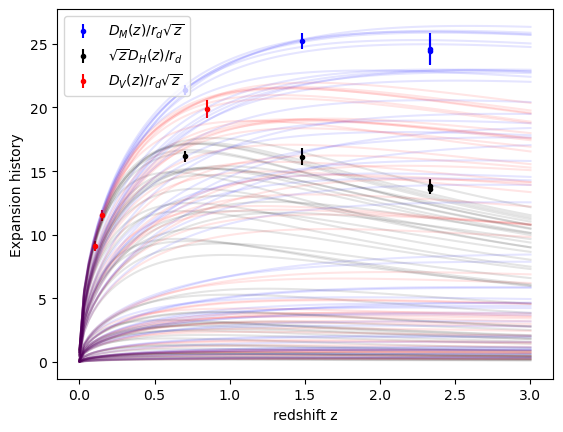

In [533]:
# --- PLOT DATA WITH ESTIMATED PARAMS -----

# data
plt.errorbar(x_D_mh_over_rd, y_D_m_over_rd/np.sqrt(x_D_mh_over_rd), yerr=np.diag(yerr_D_m_over_rd/np.sqrt(x_D_mh_over_rd)), fmt=".b", capsize=0, label = r"$D_M(z)/r_d\sqrt{z}$")
plt.errorbar(x_D_mh_over_rd, y_D_h_over_rd*np.sqrt(x_D_mh_over_rd), yerr=np.diag(yerr_D_h_over_rd)*np.sqrt(x_D_mh_over_rd), fmt=".k", capsize=0, label = r"$\sqrt{z}D_H(z)/r_d$")

plt.errorbar([x_6dFGS,x_MGS,x_ELG], [y_6dFGS_Dv_over_rd/np.sqrt(x_6dFGS), y_MGS_Dv_over_rd/np.sqrt(x_MGS), y_ELG_Dv_over_rd/np.sqrt(x_ELG)],\
             yerr=[yerr_6dFGS_Dv_over_rd/np.sqrt(x_6dFGS), yerr_MGS_Dv_over_rd/np.sqrt(x_MGS), yerr_ELG_Dv_over_rd/np.sqrt(x_ELG)], fmt=".r", capsize=0, label = r"$D_V(z)/r_d\sqrt{z}$")
plt.legend()
plt.xlabel("redshift z")
plt.ylabel("Expansion history");


xl = np.linspace(0.001,3,int(1e2))
for Omg_c, h,alpha_t in flat_samples[np.random.randint(len(flat_samples), size=50)]:
    Omg_r = (2.47e-5*h**-2)*1.6949484 
    plt.plot(xl, np.sqrt(xl)*D_H_H0(xl,[Omg_c , 0.05 , 0 , Omg_r , alpha_t , 0])/r_d_H0([Omg_c , 0.05 , 0 , Omg_r , alpha_t , 0],h), color="k", alpha=0.1)
    plt.plot(xl, D_V_H0(xl,[Omg_c , 0.05 , 0 , Omg_r , alpha_t , 0])/(r_d_H0([Omg_c , 0.05 , 0 , Omg_r , alpha_t , 0],h)*np.sqrt(xl)), color="r", alpha=0.1)
    plt.plot(xl, D_M_H0(xl,[Omg_c , 0.05 , 0 , Omg_r , alpha_t , 0])/(r_d_H0([Omg_c , 0.05 , 0 , Omg_r , alpha_t , 0],h)*np.sqrt(xl)), color="b", alpha=0.1)
